In [36]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import csv
import markov_clustering as mc
from matplotlib.pylab import cm, axis
import math

In [2]:
# vectors = pd.read_feather('data/1m.ftr')
start = time.time()
vectors = pd.read_csv('data/rust_vectors.csv')
print(f'{time.time()-start:.2f}')
corr = vectors.corr()
vectors.shape

13.99


(5203319, 45)

In [3]:
vectors.isnull().values.any()

False

In [5]:
vectors.head()

,Special Gasoline,Special Diesel,Lubricant,Diesel Auto Clean,Gasoline,Several,Filters,Additives And Fluids,Ethanol,Cigarettes,...,Toys,Covers,Pastas,Popcorn,Sweet Coconut James,Batteries,Mate Herb,Perfumery,Chas Juice Cafe In Powder,Special Diesel S10
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Plot Correlation Matrix 

In [6]:
def triangle_map(corrmat):
    fig, ax = plt.subplots(figsize=(12,12))
    df_lt = corrmat.where(np.tril(np.ones(corrmat.shape)).astype(np.bool))
    sns.heatmap(df_lt, cmap='binary', square=True, linewidths=0.2)
    plt.show()

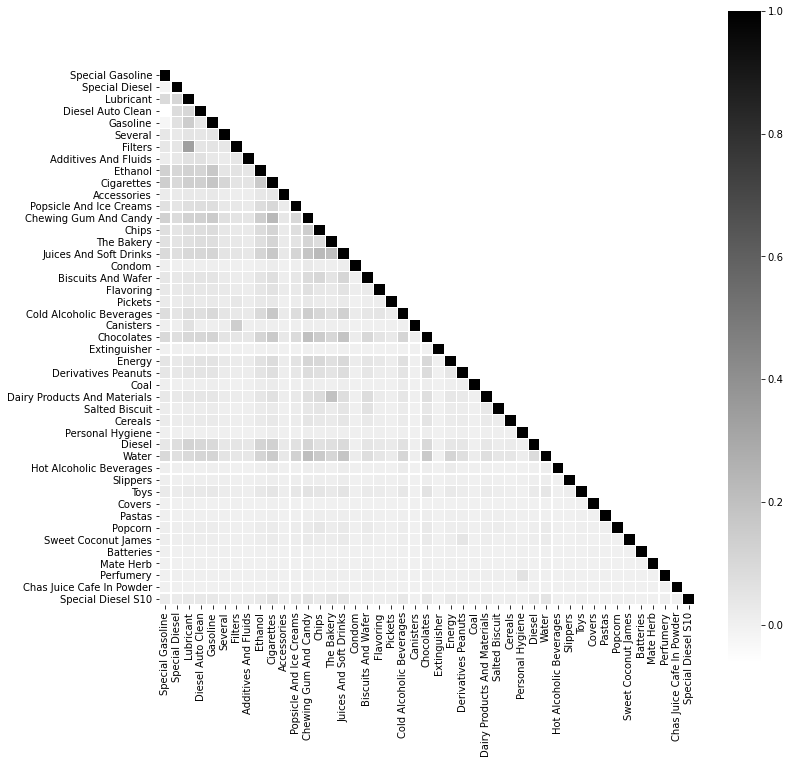

In [7]:
triangle_map(corr)

### Make Graph

### The distance function, i.e.: $\sqrt{2 (1-x)}$
This transforms the edges such that the smaller the edge value, the greater the correlation, therefore allowing us to use an MST to derive the strongest connections.

In [8]:
# Vectorized distance function to transform matrix
def dfunc(cell):
        return np.sqrt(2 * (1 - cell))

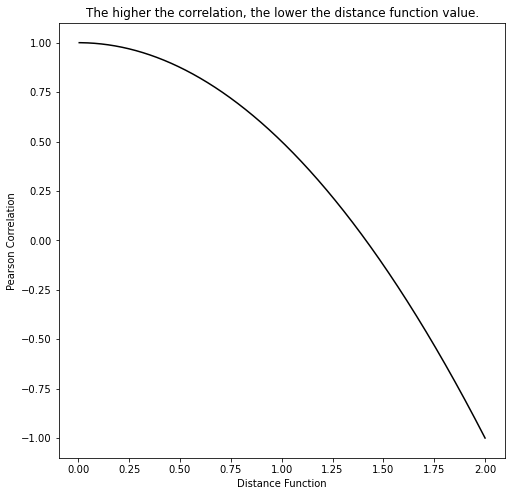

In [13]:
temp = np.arange(-1, 1, 0.00001)
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(dfunc(temp), temp, 'k')
plt.xlabel("Distance Function")
plt.ylabel("Pearson Correlation")
plt.title("The higher the correlation, the lower the distance function value.")
plt.show()

In [14]:
# Draw a graph with the specified parameters
def draw(G, pos, ax, labels, node_color='c', node_size=400, width=1, edge_color='0.25', font_size=15):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_color, node_size=node_size)
    nx.draw_networkx_edges(G, pos, ax=ax, width=width, edge_color=edge_color)
    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=font_size)

In [15]:
# Global variables
limit = None

# Gen label mapping
cols = vectors.columns[:limit] if limit else vectors.columns
numerical_labels = {cols[i]:str(i) for i in range(len(cols))}
labels = {i:cols[i] for i in range(len(cols))}
#legend = list(zip(labels, cols))

# Boolean flag to use distance function defined above
use_distance = True
# Make graphs 
corrmat = np.array(vectors.corr())
corrmat = np.absolute(corrmat)
corrmat = dfunc(corrmat) if use_distance else corrmat
corrmat = corrmat[:limit, :limit] if limit else corrmat
G = nx.from_numpy_matrix(corrmat) # Graph
G = nx.relabel_nodes(G, labels) # Not needed anymore

# Uniform layout for all plots to follow

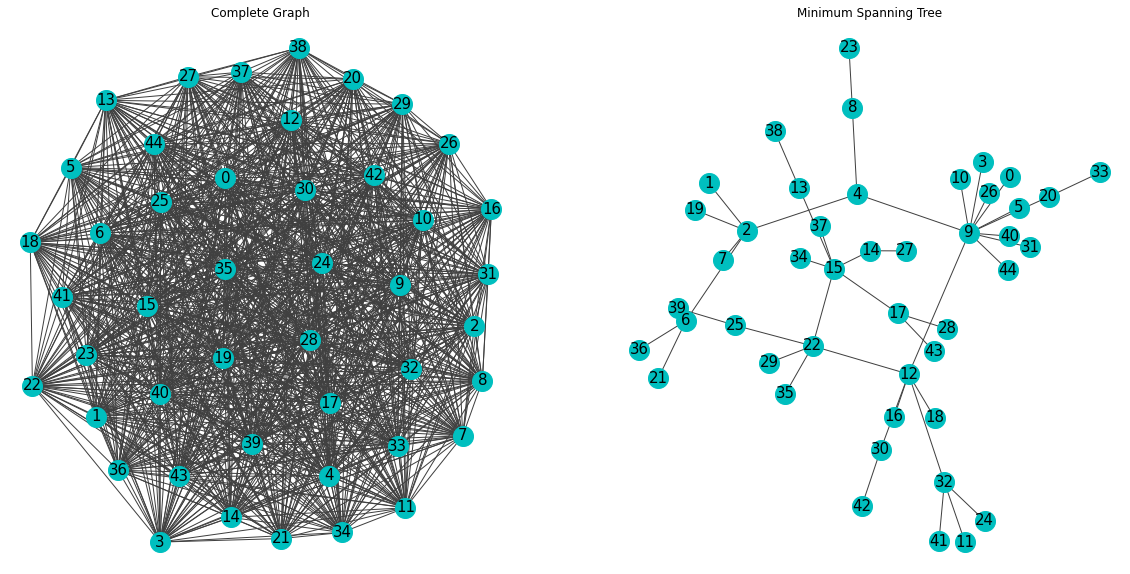

In [16]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Relabeled with integers for nodes
G2 = nx.relabel_nodes(G, numerical_labels)

# Minimum Spanning Tree
MST = nx.minimum_spanning_tree(G)
# Relabeled with integers for nodes
MST2 = nx.relabel_nodes(MST, numerical_labels)
# Draw Complete Graph
ax[0].set_title("Complete Graph")
nx.draw(G2,pos=nx.spring_layout(G2), with_labels=True, 
        ax=ax[0], node_color='c', 
        node_size=400, width=1, 
        edge_color='0.25', font_size=15)

# Draw Minimum Spanning Tree
ax[1].set_title("Minimum Spanning Tree")
mst_pos = nx.spring_layout(MST2)
nx.draw(MST2, pos=mst_pos
        , with_labels=True, 
        ax=ax[1], node_color='c', 
        node_size=400, width=1, 
        edge_color='0.25', font_size=15)



In [17]:
def print_clusters(clusters, categories):
    
    for x, cluster in enumerate(clusters):
        named = [categories[i] for i in cluster]
        print(f'Cluster #{x}: {named}')

In [58]:
# Identify optimal inflation values using the modularity as metric
def get_optimal_clusters(matrix):
    best_score = (-math.inf)
    best_clusters = None
    inflation_ranges = np.arange(1.5, 2.6, 0.1)
    for inflation in inflation_ranges:
        result = mc.run_mcl(matrix, inflation=inflation)
        clusters = mc.get_clusters(result)
        Q = mc.modularity(matrix=result, clusters=clusters)
        if Q > best_score:
            best_score = Q
            best_clusters = clusters
    return best_clusters

In [55]:
def draw_clusters(graph, clusters, **kwargs):
    # map node to cluster id for colors
    cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
    colors = [cluster_map[i] for i in range(len(graph.nodes()))]
    
    # if colormap not specified in kwargs, use a default
    if not kwargs.get("cmap", False):
        kwargs["cmap"] = cm.tab20
    
    # draw
    nx.draw_networkx(graph, node_color=colors, **kwargs)
    axis("off")

Cluster #0: ['Special Gasoline', 'Diesel Auto Clean', 'Several', 'Ethanol', 'Cigarettes', 'Accessories', 'Cold Alcoholic Beverages', 'Coal', 'Diesel', 'Hot Alcoholic Beverages', 'Batteries', 'Special Diesel S10']
Cluster #1: ['Special Diesel', 'Lubricant', 'Gasoline', 'Filters', 'Additives And Fluids', 'Pickets', 'Canisters', 'Extinguisher', 'Covers']
Cluster #2: ['Popsicle And Ice Creams', 'Energy', 'Water', 'Mate Herb']
Cluster #3: ['Chewing Gum And Candy', 'Condom', 'Flavoring', 'Personal Hygiene', 'Perfumery']
Cluster #4: ['Chips', 'The Bakery', 'Juices And Soft Drinks', 'Biscuits And Wafer', 'Dairy Products And Materials', 'Salted Biscuit', 'Slippers', 'Pastas', 'Popcorn', 'Chas Juice Cafe In Powder']
Cluster #5: ['Chocolates', 'Derivatives Peanuts', 'Cereals', 'Toys', 'Sweet Coconut James']


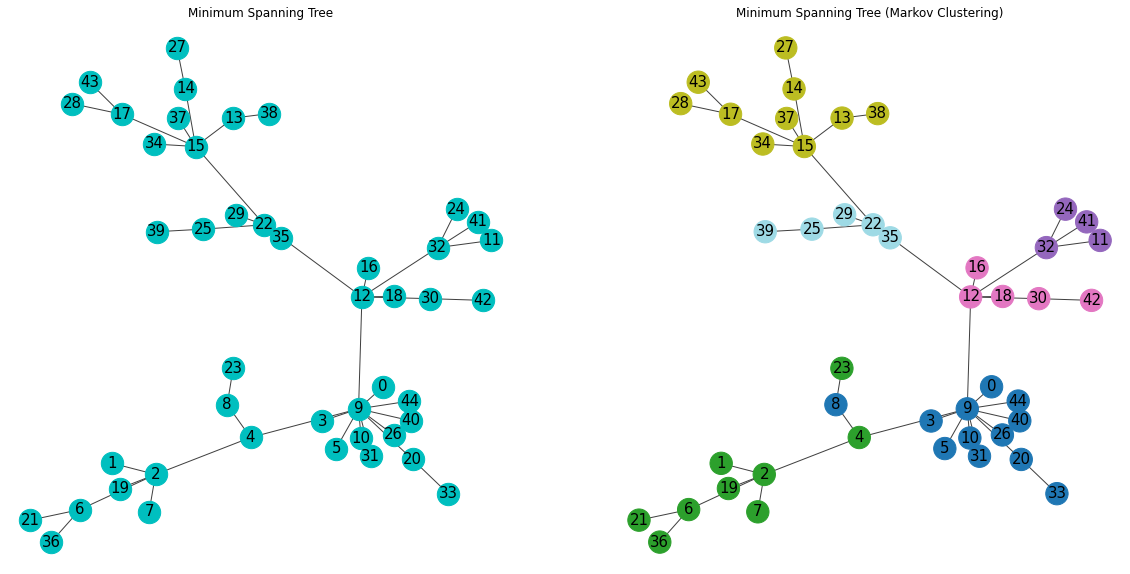

In [59]:
nrows, ncols = 1,2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))


matrix = nx.to_scipy_sparse_matrix(MST2)
clusters = get_optimal_clusters(matrix)

# Draw Minimum Spanning Tree
ax[0].set_title("Minimum Spanning Tree")
ax[1].set_title("Minimum Spanning Tree (Markov Clustering)")
mst_pos = nx.spring_layout(MST2)
nx.draw(MST2, pos=mst_pos
        , with_labels=True, 
        ax=ax[0], node_color='c', 
        node_size=500, width=1, 
        edge_color='0.25', font_size=15)

draw_clusters(MST2, clusters, pos=mst_pos, with_labels=True, 
        ax=ax[1],
        node_size=500, width=1, 
        edge_color='0.25', font_size=15)
print_clusters(clusters, cols)

In [60]:
# Sort the edges by shortest values (i.e. closest relations)
E = [(a,b,c['weight']) for (a,b,c) in MST.edges(data=True)]
E = sorted(E, key=lambda x: x[2], reverse=False)

for edge in E:
    print(f'{edge[0].rjust(25)} -> {edge[1].ljust(30)}: {edge[2]:.8f}')

                Lubricant -> Filters                       : 1.15329696
               Cigarettes -> Chewing Gum And Candy         : 1.24075217
                    Chips -> Juices And Soft Drinks        : 1.24559884
               The Bakery -> Juices And Soft Drinks        : 1.25953533
    Chewing Gum And Candy -> Water                         : 1.26242308
    Chewing Gum And Candy -> Chocolates                    : 1.26710819
               The Bakery -> Dairy Products And Materials  : 1.27094356
   Juices And Soft Drinks -> Chocolates                    : 1.27845058
                 Gasoline -> Cigarettes                    : 1.28525564
                 Gasoline -> Ethanol                       : 1.29029897
               Cigarettes -> Cold Alcoholic Beverages      : 1.29073528
                Lubricant -> Gasoline                      : 1.30731113
         Special Gasoline -> Cigarettes                    : 1.31029521
                  Filters -> Canisters                     : 1.3

In [71]:
def format_list(list):
    returnval = ''
    for elem in list:
        returnval += f'{elem}, '
    return returnval[:-2]

In [72]:
# Sort the edges by shortest values (i.e. closest relations)
E = [(a,b,c['weight']) for (a,b,c) in MST.edges(data=True)]
E = sorted(E, key=lambda x: x[2], reverse=False)

rules = {}

for edge in E:
    if edge[0] in rules:
        rules[edge[0]].append(edge[1])
    else:
        rules[edge[0]] = [edge[1]]

for a in rules:
    print(f'{a.rjust(25)} -> {format_list(rules[a])}')

                Lubricant -> Filters, Gasoline, Additives And Fluids, Pickets
               Cigarettes -> Chewing Gum And Candy, Cold Alcoholic Beverages, Diesel, Special Diesel S10, Accessories, Coal, Batteries
                    Chips -> Juices And Soft Drinks, Popcorn
               The Bakery -> Juices And Soft Drinks, Dairy Products And Materials
    Chewing Gum And Candy -> Water, Chocolates, Flavoring, Condom, Personal Hygiene
   Juices And Soft Drinks -> Chocolates, Biscuits And Wafer, Slippers, Pastas
                 Gasoline -> Cigarettes, Ethanol
         Special Gasoline -> Cigarettes
                  Filters -> Canisters, Covers
        Diesel Auto Clean -> Cigarettes
  Popsicle And Ice Creams -> Water
                   Energy -> Water
           Special Diesel -> Lubricant
                  Several -> Cigarettes
               Chocolates -> Derivatives Peanuts, Toys, Cereals
       Biscuits And Wafer -> Salted Biscuit, Chas Juice Cafe In Powder
         Personal Hygi

### Export Graph 

In [ ]:
# export ordered labels
with open("data/labels.csv","w+") as f:
    wr = csv.writer(f)
    wr.writerow(cols)

In [ ]:
# Convert ndarray value to list
temp = pos
for key in temp:
    temp[key] = list(temp[key])
# Export node positional data
with open('data/positional_data.json', 'w+') as f:
    json.dump(temp, f)

In [ ]:
# For D3.JS
# Example: https://bl.ocks.org/mbostock/4062045
JSON_graph = nx.node_link_data(MST)

In [ ]:
JSON_graph

In [ ]:
# Example on how to re-import and draw

# Import graph
temp = nx.node_link_graph(JSON_graph)

# Import positional data
temp_pos = json.load(open('data/positional_data.json'))
labels = {}
for key in temp_pos:
    pos[key] = temp_pos[key]
    
# Import label ordering
with open('data/labels.csv') as f:
    for row in csv.reader(f):
        cols = list(row)

# label map
labels = {i:cols[i] for i in range(len(cols))}
legend = list(zip(labels, cols))

# Axes to draw on
nrows, ncols = 1,1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

# Draw full graph
draw(temp, pos, ax, labels)